# **Introduction of Dataset**

**Context**

This dataset contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. This dataset was taken from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/index.php

**Content**

The dataset contains 9357 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year) representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.

**Data Definition**:

1 Time (HH.MM.SS)

2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)

3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)

4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)

5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)

6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)

7 True hourly averaged NOx concentration in ppb (reference analyzer)

8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)

9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)

10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)

11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)

12 Temperature in Â°C

13 Relative Humidity (%)

14 AH Absolute Humidity

**Problem Definition**

1. How is the characteristic of air pollution in Italy ?

2. How is the correlation among those variables ?

3. When is the period with the most polluted in Italy ?

# **Code Preparation**

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                      25KB  2023-04-13 09:55:16          41167       1193  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                            6KB  2023-05-28 18:26:48           7367        191  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                22KB  2023-05-12 13:06:39           8963        187  1.0              
mohithsairamreddy/salary-data                

In [ ]:
!kaggle datasets download -d 'fedesoriano/air-quality-data-set'

  0% 0.00/248k [00:00<?, ?B/s]
100% 248k/248k [00:00<00:00, 139MB/s]


In [ ]:
import zipfile

In [ ]:
dataset_zip = zipfile.ZipFile('/content/air-quality-data-set.zip','r')

dataset_zip.extractall()

dataset_zip.close()

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler     # to sacalling different attribute
from sklearn import cluster                                                    # for machine learning and statistical modelling (we use it for clustering)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, r2_score, f1_score, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# **Raw Data Preparation**

In [ ]:
df_ori=pd.read_csv("/content/AirQuality.csv",sep=';')
df_ori.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [ ]:
df_ori.info()
df_ori.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


(9471, 17)

let's split the column into numerical column & categorical column

# **Cleaning Data**

Cleaning Data:
- data type
- missing data
- typos
- duplicates
- drop unnecesary columns
- timeseries manipulation
- outlier

check missing data

In [ ]:
df_dc = df_ori.copy()

In [ ]:
#change format to date time
df_dc['Date'] = pd.to_datetime(df_dc['Date'], format='%d/%m/%Y')
df_dc['Time'] = pd.to_datetime(df_dc['Time'], format='%H.%M.%S').dt.time

In [ ]:
#turn ',' to '.' so that read as float
df_dc.replace(to_replace=',',value='.',regex=True,inplace=True)

In [ ]:
#turn object type into number/float type
df_dc['CO(GT)'] = pd.to_numeric(df_dc['CO(GT)'],errors = 'coerce')
df_dc['C6H6(GT)'] = pd.to_numeric(df_dc['C6H6(GT)'],errors = 'coerce')
df_dc['T'] = pd.to_numeric(df_dc['T'],errors = 'coerce')
df_dc['RH'] = pd.to_numeric(df_dc['RH'],errors = 'coerce')
df_dc['AH'] = pd.to_numeric(df_dc['AH'],errors = 'coerce')

In [ ]:
#drop unnecessary columns, NMHC(GT) dropped due to unvalid result
drop_columns = ['Unnamed: 15', 'Unnamed: 16','NMHC(GT)']
df_dc = df_dc.drop(drop_columns, axis=1)
df_dc = df_dc.dropna()

In [ ]:
df_dc.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [ ]:
df_dc.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
df_dc.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [ ]:
#DATA CLEAN FIX
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   C6H6(GT)       9357 non-null   float64       
 5   PT08.S2(NMHC)  9357 non-null   float64       
 6   NOx(GT)        9357 non-null   float64       
 7   PT08.S3(NOx)   9357 non-null   float64       
 8   NO2(GT)        9357 non-null   float64       
 9   PT08.S4(NO2)   9357 non-null   float64       
 10  PT08.S5(O3)    9357 non-null   float64       
 11  T              9357 non-null   float64       
 12  RH             9357 non-null   float64       
 13  AH             9357 non-null   float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 1.1+ MB


In [ ]:
numerical_column = ['CO(GT)','PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']

In [ ]:
#replace outliers with median
median = float(df_dc['CO(GT)'].median())
df_dc["CO(GT)"] = np.where(df_dc["CO(GT)"] < 0, median, df_dc['CO(GT)'])

median = float(df_dc['PT08.S1(CO)'].median())
df_dc["PT08.S1(CO)"] = np.where(df_dc["PT08.S1(CO)"] < 0, median, df_dc['PT08.S1(CO)'])

median = float(df_dc['C6H6(GT)'].median())
df_dc["C6H6(GT)"] = np.where(df_dc["C6H6(GT)"] < 0, median, df_dc['C6H6(GT)'])

median = float(df_dc['PT08.S2(NMHC)'].median())
df_dc["PT08.S2(NMHC)"] = np.where(df_dc["PT08.S2(NMHC)"] < 0, median, df_dc['PT08.S2(NMHC)'])

median = float(df_dc['NOx(GT)'].median())
df_dc["NOx(GT)"] = np.where(df_dc["NOx(GT)"] < 0, median, df_dc['NOx(GT)'])

median = float(df_dc['PT08.S3(NOx)'].median())
df_dc["PT08.S3(NOx)"] = np.where(df_dc["PT08.S3(NOx)"] < 0, median, df_dc['PT08.S3(NOx)'])

median = float(df_dc['NO2(GT)'].median())
df_dc["NO2(GT)"] = np.where(df_dc["NO2(GT)"] < 0, median, df_dc['NO2(GT)'])

median = float(df_dc['PT08.S4(NO2)'].median())
df_dc["PT08.S4(NO2)"] = np.where(df_dc["PT08.S4(NO2)"] < 0, median, df_dc['PT08.S4(NO2)'])

median = float(df_dc['PT08.S5(O3)'].median())
df_dc["PT08.S5(O3)"] = np.where(df_dc["PT08.S5(O3)"] < 0, median, df_dc['PT08.S5(O3)'])

median = float(df_dc['T'].median())
df_dc["T"] = np.where(df_dc["T"] < 0, median, df_dc['T'])

median = float(df_dc['RH'].median())
df_dc["RH"] = np.where(df_dc["RH"] < 0, median, df_dc['RH'])

median = float(df_dc['AH'].median())
df_dc["AH"] = np.where(df_dc["AH"] < 0, median, df_dc['AH'])

# **EDA**



In [ ]:
df_dc.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.035343,1098.001282,9.997713,937.426312,228.347547,833.870578,110.092017,1455.863097,1019.741477,18.299134,49.209394,1.023624
std,1.339737,212.985308,7.314906,261.700283,197.570902,251.872460,44.399549,339.373394,390.927152,8.631100,16.975247,0.395948
min,0.100000,647.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,0.000000,9.200000,0.184700
25%,1.200000,941.000000,4.600000,743.000000,112.000000,666.000000,86.000000,1242.000000,742.000000,12.000000,36.600000,0.746100
50%,1.500000,1053.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


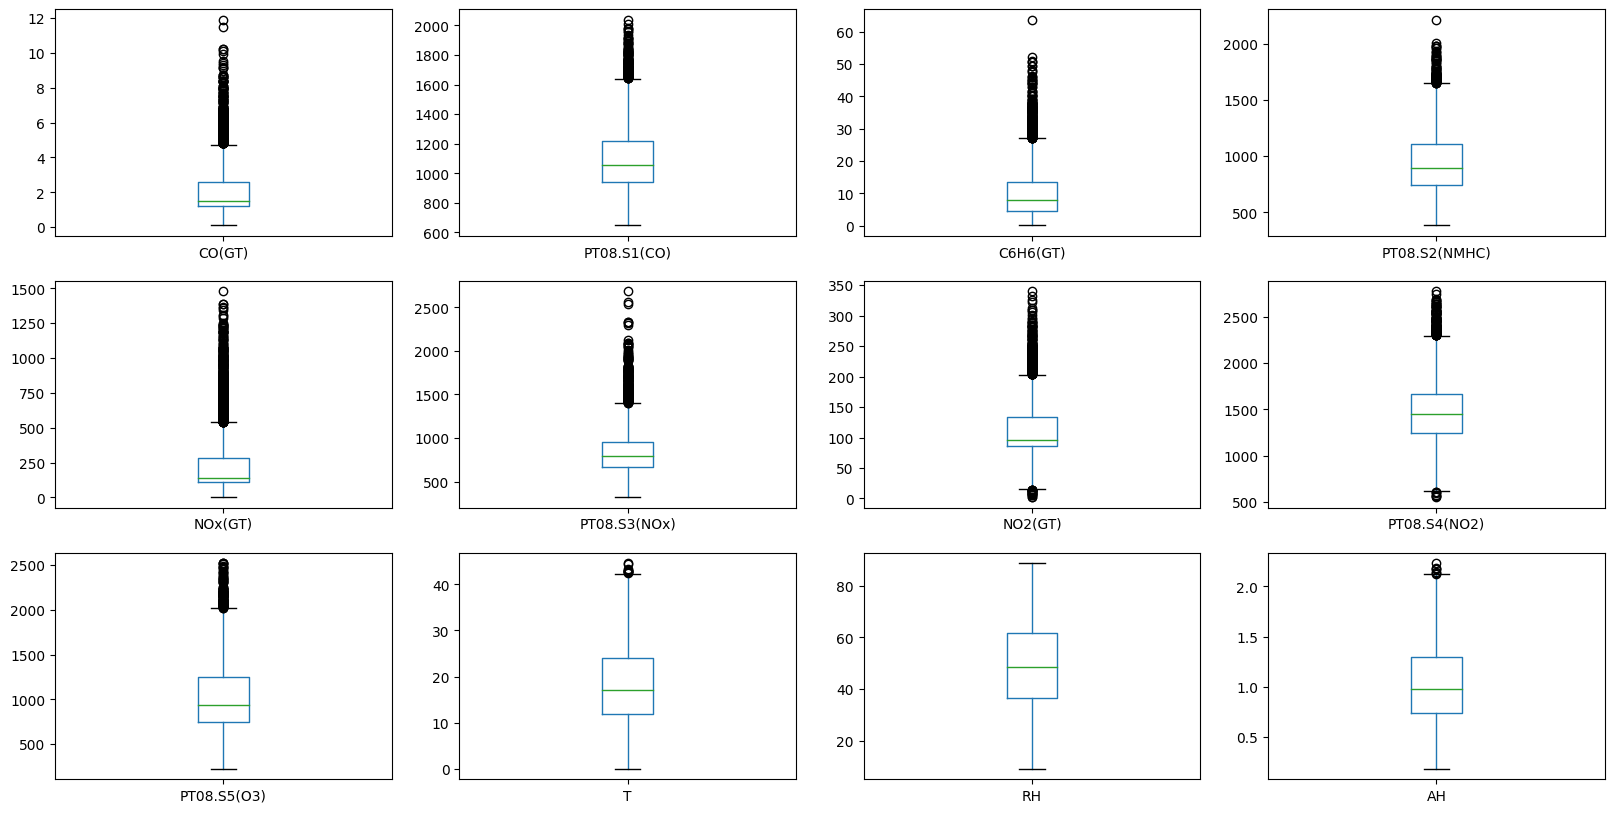

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(20,10))

for i,el in enumerate(numerical_column):
    a = df_dc.boxplot(el, ax=axes.flatten()[i],grid=False)

plt.show()

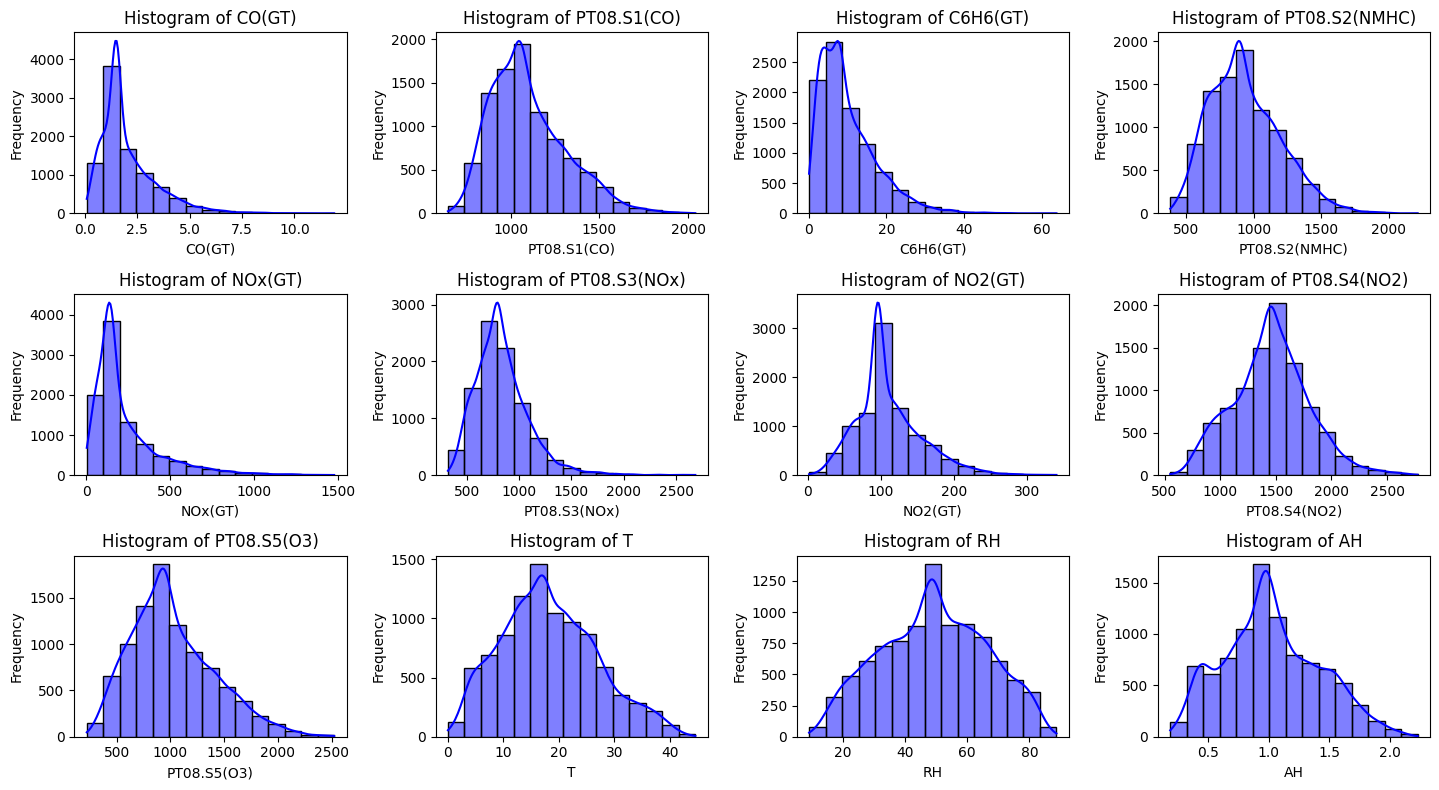

In [ ]:
num_rows = 3
num_cols = 4

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the numerical columns and create histograms
for i, column in enumerate(numerical_column):
    sns.histplot(x=df_dc[column], stat="count", color="blue", bins=15, kde={'alpha': 0.5}, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-34-5e75c59defc4>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_dc[numerical_column].corr(), dtype=np.bool))


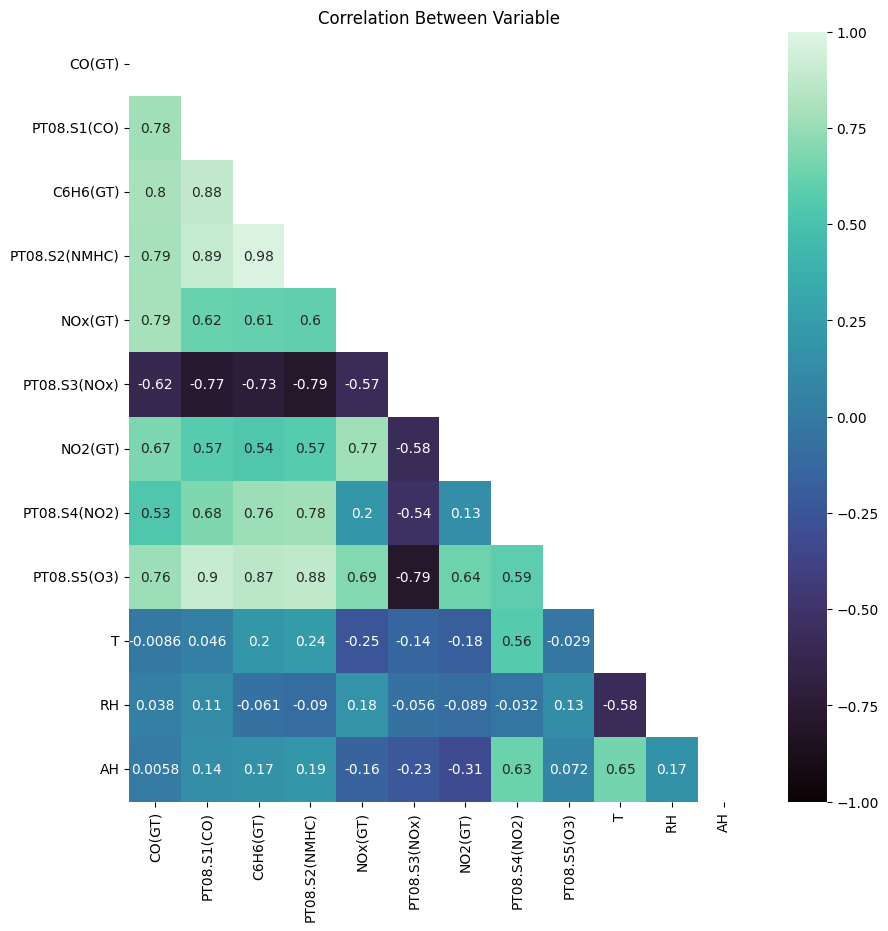

In [ ]:
#find correlation among variables
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Correlation Between Variable')

mask = np.triu(np.ones_like(
    df_dc[numerical_column].corr(), dtype=np.bool))

sns.heatmap(df_dc[numerical_column].corr(),vmin=-1,
            vmax=1,cmap='mako',annot=True,mask=mask,
            annot_kws={"fontsize":10})

plt.show()

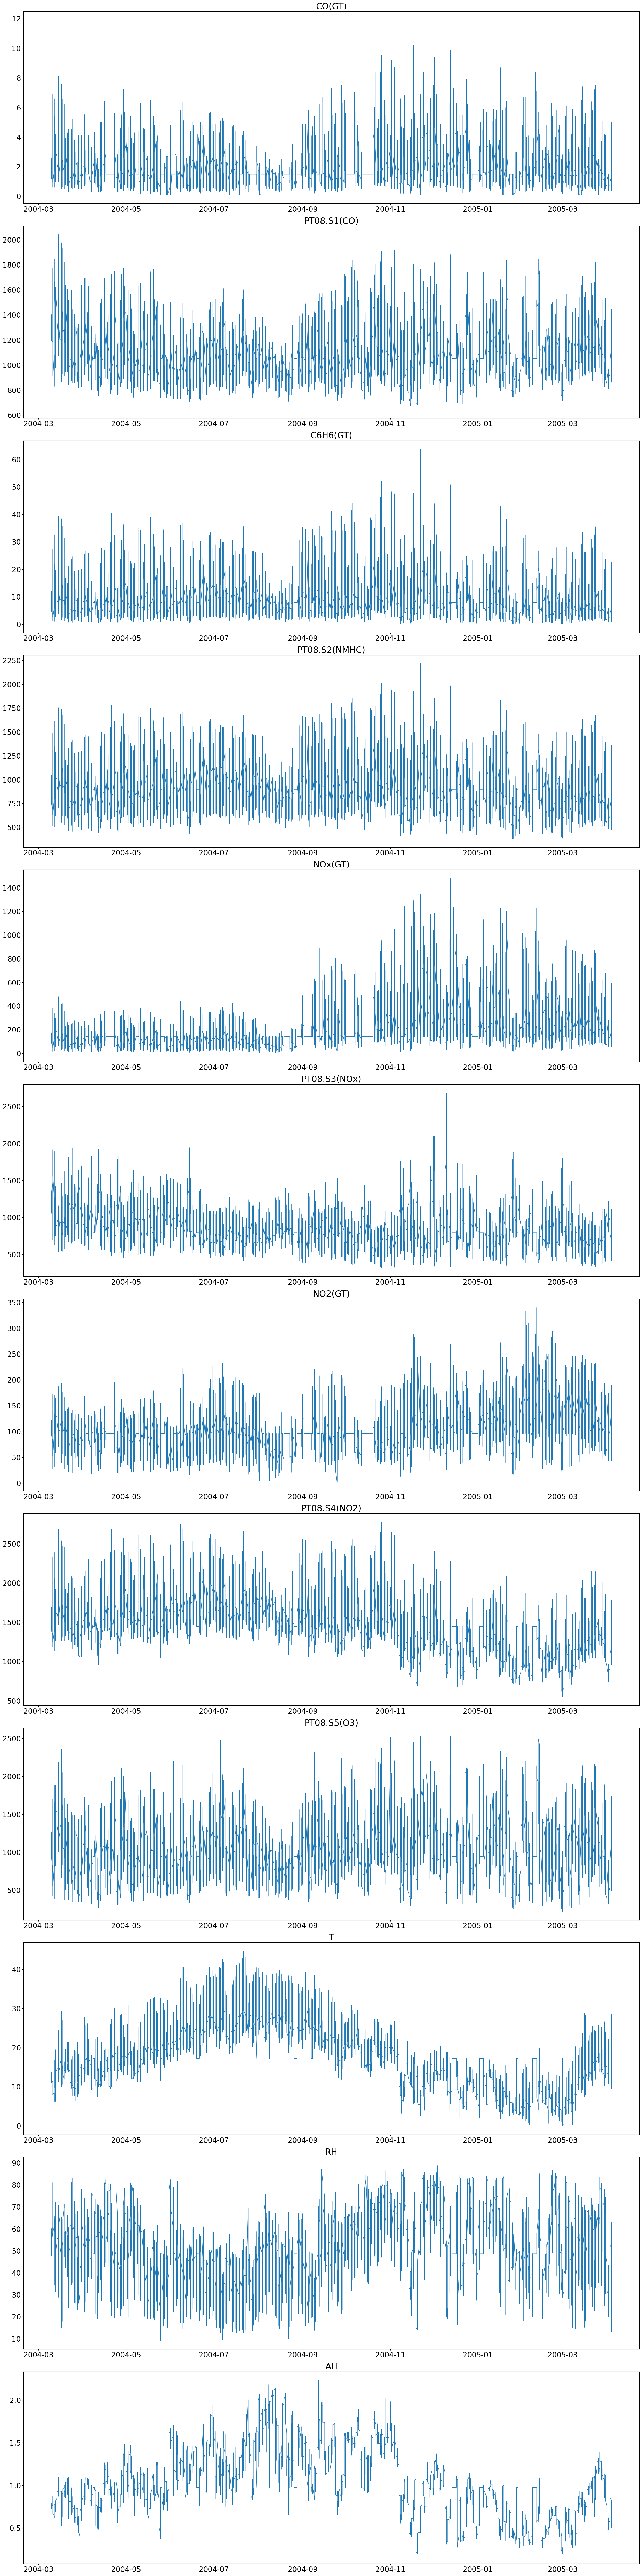

In [ ]:
#show daily fluctuation

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(25, 100))

# Flatten the axes array
axes = axes.flatten()

# Specify the 12 columns
columns = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
           'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Iterate over the columns and create different charts
for i, column in enumerate(columns):
    ax = axes[i]  # Select the current subplot
    ax.set_title(column, fontsize=24)  # Set the title of the subplot to the column name
    ax.plot(df_dc['Date'], df_dc[column])
    ax.tick_params(axis='both', which='major', labelsize=20)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_month=df_dc.copy()

<ipython-input-37-8a442e940a9f>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df_month.resample('M').mean()


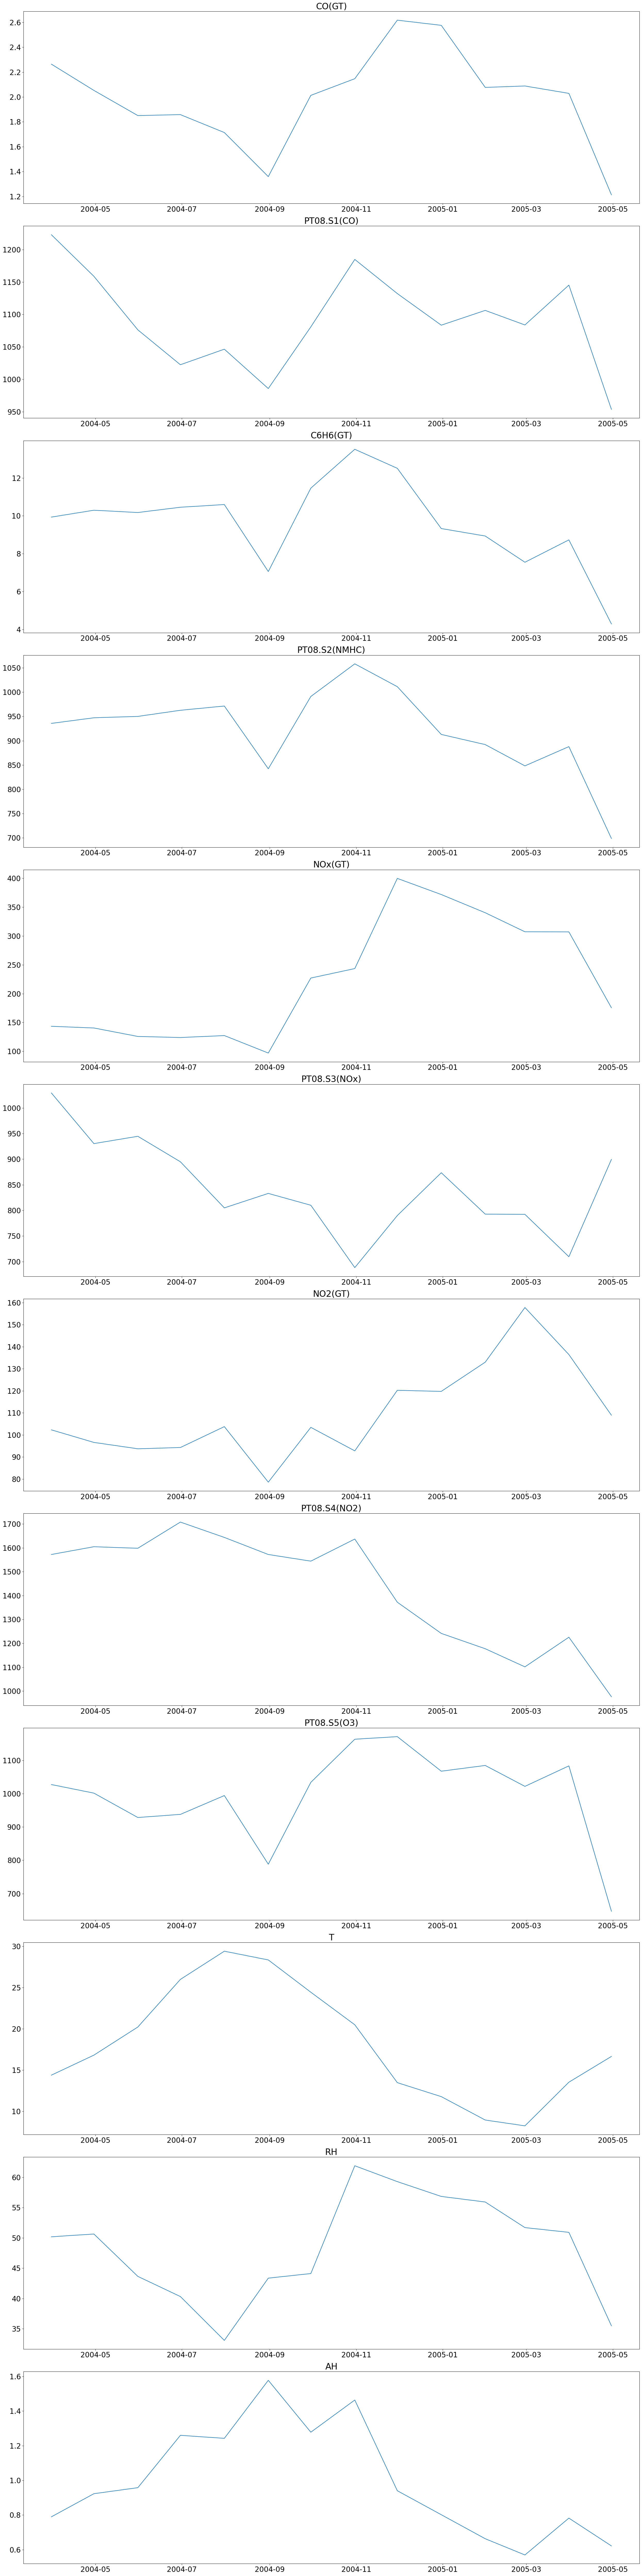

In [ ]:
df_month.set_index('Date', inplace=True)

# Resample the data to monthly frequency
df_monthly = df_month.resample('M').mean()

# Create the subplots
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(25, 100))
axes = axes.flatten()

columns = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
           'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Iterate over the columns and create different charts
for i, column in enumerate(columns):
    ax = axes[i]
    ax.set_title(column, fontsize=24)
    ax.plot(df_monthly.index, df_monthly[column])
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()